# Neural Computing Coursework


## PREDICTION OF ONLINE SHOPPERS PURCHASING USING NC METHODS
### Austin Wright


Data Obtained From UCI https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import sklearn

In [2]:
data_X = pd.read_csv('DataX.csv').to_numpy()
data_Y = pd.read_csv('DataY.csv').to_numpy()

In [3]:
features_train, features_test, targets_train, targets_test = train_test_split(data_X,
                                                                             data_Y,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 


In [268]:
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate


### MLP WORK:

In [23]:
# ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2, hidden_dim3, output_dim,dropout=0.25):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1) 
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        
        
        self.fc3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.relu3 = nn.ReLU()
        
        
        self.fc4 = nn.Linear(hidden_dim3, output_dim)  
        self.sig1 = nn.Sigmoid()
        
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
 
        out = self.fc1(x)
        out = self.relu1(out)
   
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout(out)
    
        out = self.fc3(out)
        out = self.relu3(out)
    
  
        out = self.fc4(out)
        out = self.sig1(out)
        
        return out

In [289]:
def train_ANN(parameters):
    model = ANNModel(np.shape(features_train)[1], parameters.get('hs1',10), parameters.get('hs2',10)
                     , parameters.get('hs3',10), 1,parameters.get('do',0.25))
    optimizer =torch.optim.Adam(model.parameters(), lr=parameters.get('lr',0.001))
    error = nn.BCELoss()

    for epoch in range(parameters.get('epochs',100)):
        inputs = torch.from_numpy(features_train).type(torch.FloatTensor)
        labels = torch.from_numpy(targets_train)
    
        
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = error(outputs, labels.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
    
    
        out_bool = outputs.detach().numpy() > 0.5
        out_bin  = out_bool.astype(int)
    
    outputs = model.forward(inputs)
    out_bool = outputs.detach().numpy() > 0.5
    out_bin  = out_bool.astype(int)
    acc_train = np.sum((out_bin == targets_train))/len(targets_train)
    
    
    return acc_train 




In [517]:
best_parameters_ANN, values_ANN, experiment_ANN, model_ANN = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.01], "log_scale": True,"value_type":'float'},
        {"name": "hs1", "type": "range", "bounds": [1, 256],"value_type":'int'},
        {"name": "hs2", "type": "range", "bounds": [1, 256],"value_type":'int'},
        {"name": "hs3", "type": "range", "bounds": [1, 256],"value_type":'int'},
        {"name": "epochs", "type": "range", "bounds": [1, 5000],"value_type":'int'},
        {"name": "do", "type": "range", "bounds": [0, 0.5],"value_type":'float'},        
    ],
  
    evaluation_function=train_ANN,
    objective_name='accuracy',
)

print(best_parameters_ANN)
means_ANN, covariances_ANN = values_ANN
print(means_ANN)
print(covariances_ANN)

[INFO 04-08 12:31:51] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 6 trials, GPEI for subsequent trials]). Iterations after 6 will take longer to generate due to  model-fitting.
[INFO 04-08 12:31:51] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 04-08 12:31:51] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-08 12:32:43] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-08 12:33:38] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-08 12:33:43] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-08 12:35:52] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-08 12:41:12] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-08 12:45:08] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-08 12:48:28] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-08 

{'lr': 0.0014326430984293159, 'hs1': 122, 'hs2': 168, 'hs3': 97, 'epochs': 3909, 'do': 0.2861667156673784}
{'accuracy': 0.9980362531000202}
{'accuracy': {'accuracy': 4.470552972326796e-05}}


In [535]:
best_objectives_ANN = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot_ANN = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot_ANN)

render(plot_contour(model=model_ANN, param_x='epochs', param_y='lr', metric_name='accuracy'))
render(plot_contour(model=model_ANN, param_x='epochs', param_y='hs1', metric_name='accuracy'))
render(plot_contour(model=model_ANN, param_x='epochs', param_y='hs2', metric_name='accuracy'))
render(plot_contour(model=model_ANN, param_x='epochs', param_y='hs3', metric_name='accuracy'))
render(plot_contour(model=model_ANN, param_x='epochs', param_y='do', metric_name='accuracy'))

In [70]:
#FUNCTION TO TRAIN ANN
def ann_train(xdata,ydata,num_features=16,learning_rate=0.00143,
              hs1=122,hs2=168,hs3=97,epochs=3909,do=0.2861):
    
    model = ANNModel(num_features,hs1,hs2,hs3,1,do)
    
    
    optimizer =torch.optim.Adam(model.parameters(), lr=learning_rate)
    error = nn.BCELoss()
    
    
    acc = []
    save_loss = []
    
    for epoch in range(epochs):
        inputs = torch.from_numpy(features_train).type(torch.FloatTensor)
        labels = torch.from_numpy(targets_train)
    
        
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = error(outputs, labels.type(torch.FloatTensor))
        
        
        loss.backward()
        optimizer.step()
    
    
        out_bool = outputs.detach().numpy() > 0.5
        out_bin  = out_bool.astype(int)
    
        outputs = model.forward(inputs)
        out_bool = outputs.detach().numpy() > 0.5
        out_bin  = out_bool.astype(int)
        acc_train = np.sum((out_bin == targets_train))/len(targets_train)
        
        
        save_loss.append(loss.item())
        acc.append(acc_train); 
        
        if epoch%100==0:
            print('EPOCH:',epoch,'LOSS:',loss.item(),'ACC. TRAIN:',acc_train)
    
    return model,acc,save_loss
    

In [90]:
import time
tic = time.time()
model_final,acc,loss = ann_train(features_train,targets_train)
toc = time.time()



EPOCH: 0 LOSS: 0.6784842610359192 ACC. TRAIN: 0.8460914529047957
EPOCH: 100 LOSS: 0.23715680837631226 ACC. TRAIN: 0.8987123593227213
EPOCH: 200 LOSS: 0.1877574473619461 ACC. TRAIN: 0.9162526614620298
EPOCH: 300 LOSS: 0.144435852766037 ACC. TRAIN: 0.935820744195478
EPOCH: 400 LOSS: 0.1123172715306282 ACC. TRAIN: 0.9564027172259961
EPOCH: 500 LOSS: 0.08948160707950592 ACC. TRAIN: 0.9664402311669877
EPOCH: 600 LOSS: 0.06772150099277496 ACC. TRAIN: 0.972016627800872
EPOCH: 700 LOSS: 0.053793489933013916 ACC. TRAIN: 0.9812430295042076
EPOCH: 800 LOSS: 0.0445958711206913 ACC. TRAIN: 0.9829666430092264
EPOCH: 900 LOSS: 0.03351852297782898 ACC. TRAIN: 0.9871235932272128
EPOCH: 1000 LOSS: 0.03477190062403679 ACC. TRAIN: 0.9897597079995945
EPOCH: 1100 LOSS: 0.025475258007645607 ACC. TRAIN: 0.9915847105343202
EPOCH: 1200 LOSS: 0.025824176147580147 ACC. TRAIN: 0.992902767920511
EPOCH: 1300 LOSS: 0.021359780803322792 ACC. TRAIN: 0.993308324039339
EPOCH: 1400 LOSS: 0.019635317847132683 ACC. TRAIN: 0

In [91]:
print(toc-tic)

526.4224033355713


In [24]:
#torch.save(ann1,'final_model1')
model_save_test = torch.load('final_model1')

In [25]:
out_bool = model_save_test.forward(torch.FloatTensor(features_train)).detach().numpy()  > 0.5
out_bin  = out_bool.astype(int)
acc_train = np.sum((out_bin == targets_train))/len(targets_train)
print(acc_train)        

0.9987833316435162


In [451]:
FINAL_EVAL = pd.DataFrame()

In [452]:
FINAL_EVAL['Loss'] = loss1
FINAL_EVAL['Accuracy']  = acc1
#FINAL_EVAL['Epochs'] =  range(3753)

In [453]:
import seaborn as sns

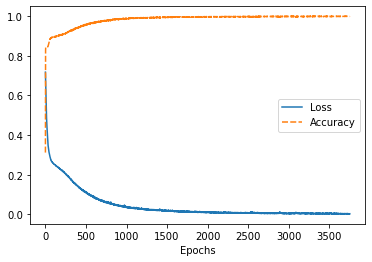

In [455]:
sns.lineplot(data=FINAL_EVAL)
plt.xlabel('Epochs')
plt.show()

In [8]:
ann1,acc1,loss1 =ann_train(features_train,targets_train)

EPOCH: 0 LOSS: 0.6997597813606262 ACC. TRAIN: 0.8456858967859677
EPOCH: 100 LOSS: 0.23566818237304688 ACC. TRAIN: 0.9001318057386191
EPOCH: 200 LOSS: 0.18831121921539307 ACC. TRAIN: 0.9166582175808577
EPOCH: 300 LOSS: 0.1460649073123932 ACC. TRAIN: 0.9401804724728784
EPOCH: 400 LOSS: 0.1129058450460434 ACC. TRAIN: 0.9553888269289262
EPOCH: 500 LOSS: 0.08417551964521408 ACC. TRAIN: 0.9637027273648991
EPOCH: 600 LOSS: 0.06661698967218399 ACC. TRAIN: 0.9745513535435466
EPOCH: 700 LOSS: 0.05143660306930542 ACC. TRAIN: 0.978708303761533
EPOCH: 800 LOSS: 0.04387112334370613 ACC. TRAIN: 0.9848930345736592
EPOCH: 900 LOSS: 0.03585376590490341 ACC. TRAIN: 0.9868194261380918
EPOCH: 1000 LOSS: 0.027906885370612144 ACC. TRAIN: 0.9893541518807665
EPOCH: 1100 LOSS: 0.024185296148061752 ACC. TRAIN: 0.9911791544154922
EPOCH: 1200 LOSS: 0.022400224581360817 ACC. TRAIN: 0.9920916556828551
EPOCH: 1300 LOSS: 0.01963476836681366 ACC. TRAIN: 0.992801378890804
EPOCH: 1400 LOSS: 0.01762090064585209 ACC. TRAIN

In [26]:
ann1 = model_save_test

In [87]:
outputs_test = ann1.forward(torch.FloatTensor(features_test))
out_bool = outputs_test.detach().numpy() > 0.5
out_bin_test  = out_bool.astype(int)
acc_test_final = np.sum((out_bin_test == targets_test))/len(targets_test)
print(acc_test_final)

0.8799675587996756


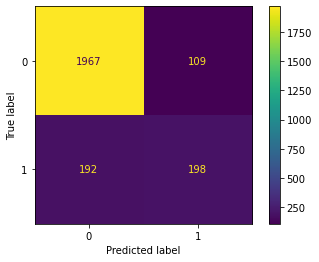

In [82]:
cm = metrics.confusion_matrix(targets_test, out_bin_test )
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

In [28]:
outputs_train = ann1.forward(torch.FloatTensor(features_train))
out_bool = outputs_train.detach().numpy() > 0.5
out_bin_train  = out_bool.astype(int)
acc_train_final = np.sum((out_bin_train == targets_train))/len(targets_train)
print(acc_train_final)

0.9983777755246882


In [30]:
from sklearn import metrics

In [77]:
fpr_test_ann, tpr_test_ann, thresholds_test_ann = metrics.roc_curve(targets_test.reshape(2466,1), 
                                                                    outputs_test.detach().numpy())

In [33]:
fpr_train_ann, tpr_train_ann, thresholds_train_ann = metrics.roc_curve(targets_train.reshape(9863,1), 
                                                                       outputs_train.detach().numpy())

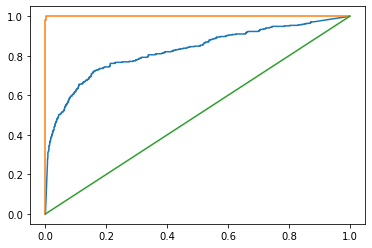

In [34]:
plt.plot(fpr_test_ann,tpr_test_ann)
plt.plot(fpr_train_ann,tpr_train_ann)
plt.plot([0,1],[0,1])

F1 SCORE ON TRAINING SET:

In [34]:
metrics.f1_score(out_bin_train, targets_train.ravel())

0.9963780046098123

F1 SCORE ON TEST SET 

In [37]:
metrics.f1_score(out_bin_test, targets_test.ravel())

0.5693641618497108

##### FIVE FOLD CROSS VALIDATION  FOR MLP

In [67]:
full_dset = np.append(data_X,data_Y,axis=1)

In [71]:
import math
CV = 5

D           = full_dset
numD        = len(D)       
k           = CV


groupz = numD/k
inds      = np.zeros((k+1,1));


for i in range(1,k):
    
    
    inds[i] = int(math.floor(groupz*(i)))

inds[-1] = numD;

p           = np.random.permutation(numD);   
D_rand      = D[p,:];

inds = inds.astype(int)
inds[0] = 0


ANN_CV_DF = pd.DataFrame()

acc_testCV  = []
acc_trainCV = []

for idx in range(1,len(inds)):
    
    
    DtestCV       = D_rand[np.arange(inds[idx-1],inds[idx]),:]; 
    DtrainCV      = D_rand[np.setdiff1d(np.arange(inds[0],inds[-1]),np.arange(inds[idx-1],inds[idx])),:];

    trainxCV      = DtrainCV[:,:-1]
    trainyCV      = DtrainCV[:,-1]
    testxCV       = DtestCV[:,:-1];
    testyCV       = DtestCV[:,-1];  
    
    
    
    
    
    model,acc,loss =ann_train(trainxCV,trainyCV)
    
    
    test2torch  = torch.from_numpy(testxCV).type(torch.FloatTensor)
    train2torch = torch.from_numpy(trainxCV).type(torch.FloatTensor)
    
    outputs  = model.forward(test2torch)
    out_bool = outputs.detach().numpy() > 0.5
    out_bin  = out_bool.astype(int)
    acc_test = np.sum((out_bin == testyCV.reshape(len(testyCV),1)))/len(testyCV)
    
    acc_testCV.append(acc_test)
    
  
    acc_trainCV.append(acc)
    
    colloss_name = 'lossCV' + str(idx)
    colacc_name  = 'accCV' + str(idx)
    
    ANN_CV_DF[colloss_name] = loss
    ANN_CV_DF[colacc_name]  = acc
    
    
    print('CV{}'.format(idx),'done')
     
    
    
    
    
    
                                                                 

EPOCH: 0 LOSS: 0.7098856568336487 ACC. TRAIN: 0.8261178140525195
EPOCH: 100 LOSS: 0.24010933935642242 ACC. TRAIN: 0.9014498631248099
EPOCH: 200 LOSS: 0.19443032145500183 ACC. TRAIN: 0.9187873872047044
EPOCH: 300 LOSS: 0.14728981256484985 ACC. TRAIN: 0.9365304674034269
EPOCH: 400 LOSS: 0.10870523750782013 ACC. TRAIN: 0.9561999391665822
EPOCH: 500 LOSS: 0.08565854281187057 ACC. TRAIN: 0.9667443982561087
EPOCH: 600 LOSS: 0.06568945944309235 ACC. TRAIN: 0.9723207948899929
EPOCH: 700 LOSS: 0.05300407484173775 ACC. TRAIN: 0.978606914731826
EPOCH: 800 LOSS: 0.04705140367150307 ACC. TRAIN: 0.9838791442765893
EPOCH: 900 LOSS: 0.0379205122590065 ACC. TRAIN: 0.9850958126330731
EPOCH: 1000 LOSS: 0.033240944147109985 ACC. TRAIN: 0.9874277603163337
EPOCH: 1100 LOSS: 0.026680393144488335 ACC. TRAIN: 0.9905708202372503
EPOCH: 1200 LOSS: 0.026116304099559784 ACC. TRAIN: 0.9915847105343202
EPOCH: 1300 LOSS: 0.022464320063591003 ACC. TRAIN: 0.9922944337422691
EPOCH: 1400 LOSS: 0.01923142746090889 ACC. TR

EPOCH: 3900 LOSS: 0.005012508016079664 ACC. TRAIN: 0.9977694413464463
CV3 done
EPOCH: 0 LOSS: 0.6918454766273499 ACC. TRAIN: 0.8457872858156747
EPOCH: 100 LOSS: 0.23492325842380524 ACC. TRAIN: 0.8995234715603772
EPOCH: 200 LOSS: 0.18797016143798828 ACC. TRAIN: 0.9179762749670486
EPOCH: 300 LOSS: 0.13938425481319427 ACC. TRAIN: 0.9396735273243435
EPOCH: 400 LOSS: 0.09952238947153091 ACC. TRAIN: 0.9566054952854102
EPOCH: 500 LOSS: 0.07807446271181107 ACC. TRAIN: 0.9672513434046436
EPOCH: 600 LOSS: 0.06257119029760361 ACC. TRAIN: 0.9743485754841326
EPOCH: 700 LOSS: 0.05668693780899048 ACC. TRAIN: 0.979316637939775
EPOCH: 800 LOSS: 0.04308436065912247 ACC. TRAIN: 0.9848930345736592
EPOCH: 900 LOSS: 0.03691285848617554 ACC. TRAIN: 0.9865152590489709
EPOCH: 1000 LOSS: 0.028967836871743202 ACC. TRAIN: 0.9886444286728177
EPOCH: 1100 LOSS: 0.026742607355117798 ACC. TRAIN: 0.9909763763560783
EPOCH: 1200 LOSS: 0.025089971721172333 ACC. TRAIN: 0.9911791544154922
EPOCH: 1300 LOSS: 0.020333815366029

KeyboardInterrupt: 

In [73]:
np.mean(acc_trainCV) #Training Set Accuracy after 5 fold CV

0.9853276664413491

<AxesSubplot:>

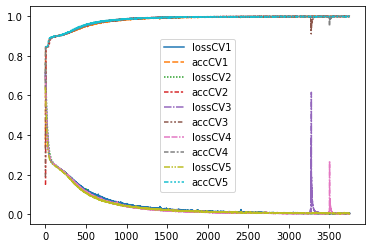

In [504]:
sns.lineplot(data=ANN_CV_DF)


In [457]:
'loss' + 'CV' + str(5)

'lossCV5'

In [255]:
outputs = model.forward(inputs)
out_bool = outputs.detach().numpy() > 0.5
out_bin  = out_bool.astype(int)
acc_train = np.sum((out_bin == targets_train))/len(targets_train)
print(acc_train,'<Training set accuracy>')

0.9978708303761533 <Training set accuracy>


In [256]:
outputs_val = model.forward(torch.from_numpy(features_test).type(torch.FloatTensor))
out_bool    = outputs_val.detach().numpy() > 0.5
out_bin     = out_bool.astype(int)

acc_test = np.sum(out_bin == targets_test)/len(targets_test)

print(acc_test,'<Test set accuracy>')

0.8673965936739659 <Test set accuracy>


In [266]:
outputs_val = model.forward(torch.from_numpy(features_test).type(torch.FloatTensor))
out_bool    = outputs_val.detach().numpy() > 0.5
out_bin     = out_bool.astype(int)


f1_score(out_bin,targets_test)

0.5490196078431373

### SUPPORT VECTOR MACHINE

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

svm_classifier_linear = SVC(C=9,kernel='linear',gamma='auto',verbose=True,probability=True)
svm_classifier_linear.fit(features_train,targets_train.ravel())
print(svm_classifier_linear.score(features_train,targets_train.ravel()),'Linear Kernel Training Acc.')
print(svm_classifier_linear.score(features_test,targets_test.ravel()),'Linear Kernel Test Acc')
print(f1_score(svm_classifier_linear.predict(features_train), targets_train.ravel()),'f1 score:train')
print(f1_score(svm_classifier_linear.predict(features_test), targets_test.ravel()),'f1 score: test')      

In [92]:
svm_classifier_rbf = SVC(C=9,kernel='rbf',gamma='auto',verbose=True,probability=True)
tic =time.time()
svm_classifier_rbf.fit(features_train,targets_train.ravel())
toc = time.time()


print(toc-tic)
print(svm_classifier_rbf.score(features_train,targets_train.ravel()),'rbf Kernel Training Acc.')
print(svm_classifier_linear.score(features_test,targets_test.ravel()),'rbfKernel Test Acc')
print(f1_score(svm_classifier_rbf.predict(features_train), targets_train.ravel()),'rbf score:train')
print(f1_score(svm_classifier_rbf.predict(features_test), targets_test.ravel()),' score: test')      

[LibSVM]12.695255279541016
0.9278110108486262 rbf Kernel Training Acc.
0.8872668288726683 rbfKernel Test Acc
0.7339312406576981 rbf score:train
0.6055045871559633  score: test


In [88]:
from joblib import dump, load
dump(svm_classifier_rbf, 'final_svm_classifier.joblib') 

['final_svm_classifier.joblib']

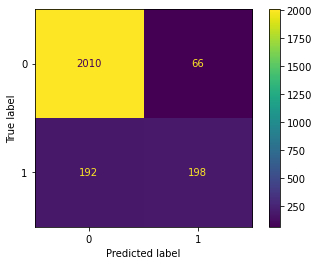

In [83]:
cm = metrics.confusion_matrix(targets_test, svm_classifier_rbf.predict(features_test) )
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

In [74]:
fpr_test_svm, tpr_test_svm, thresholds_test_svm = roc_curve(targets_test, 
                                                                  svm_classifier_rbf.predict_proba(features_test)[:,1]  )

In [75]:
fpr_train_svm, tpr_train_svm, thresholds_train_svm = roc_curve(targets_train, 
                                                                  svm_classifier_rbf.predict_proba(features_train)[:,1]  )

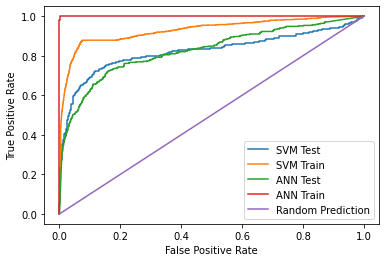

In [43]:
plt.plot(fpr_test_svm,tpr_test_svm)
plt.plot(fpr_train_svm,tpr_train_svm)
plt.plot(fpr_test_ann,tpr_test_ann)
plt.plot(fpr_train_ann,tpr_train_ann)
plt.plot([0,1],[0,1])
plt.legend(['SVM Test','SVM Train','ANN Test','ANN Train','Random Prediction'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [76]:
 metrics.auc(fpr_test_svm, tpr_test_svm)

0.8229212983548244

In [78]:
metrics.auc(fpr_test_ann, tpr_test_ann)

0.8264537325230966

Optimizing Hyperparameters for SVC

In [370]:
def train_svm(parameters):
    svm_classifier = SVC(C=parameters.get('C',1),kernel=parameters.get('Kern','linear'),
                         gamma=parameters.get('Gamma','scale'))
    
    svm_classifier.fit(features_train,targets_train.ravel())
    
    return svm_classifier.score(features_train,targets_train.ravel())

In [521]:
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "C", "type": "range", "bounds": [1, 10], "value_type":'int'},
        {"name": "Kern", "type": "choice", "values":['linear', 'poly','rbf','sigmoid']},
        {"name": "Gamma", "type": "choice", "values": ['scale','auto']},],
  
    evaluation_function=train_svm,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 04-08 15:30:36] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter Kern. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-08 15:30:36] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter Gamma. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-08 15:30:36] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-08 15:30:36] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 04-08 15:30:36] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-08 15:31:25] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-08 15:31:27] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-08 15:31:28] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-

{'C': 9, 'Kern': 'rbf', 'Gamma': 'auto'}
{'accuracy': 0.9278110108486262}
{'accuracy': {'accuracy': nan}}


In [523]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

#render(plot_contour(model=model, param_x='C', param_y='Gamma', metric_name='accuracy'))
#render(plot_contour(model=model, param_x='Kern', param_y='C', metric_name='accuracy'))


ValueError: Gamma is not a RangeParameter

In [516]:
CV = 5

D           = full_dset
numD        = len(D)       
k           = CV


groupz = numD/k
inds      = np.zeros((k+1,1));


for i in range(1,k):
    
    
    inds[i] = int(math.floor(groupz*(i)))

inds[-1] = numD;

p           = np.random.permutation(numD);   
D_rand      = D[p,:];

inds = inds.astype(int)
inds[0] = 0


SVMacc_testCV  = []
SVMacc_trainCV = []

for idx in range(1,len(inds)):
    print('CV{}'.format(idx))
    
    DtestCV       = D_rand[np.arange(inds[idx-1],inds[idx]),:]; 
    DtrainCV      = D_rand[np.setdiff1d(np.arange(inds[0],inds[-1]),np.arange(inds[idx-1],inds[idx])),:];

    trainxCV      = DtrainCV[:,:-1]
    trainyCV      = DtrainCV[:,-1]
    testxCV       = DtestCV[:,:-1];
    testyCV       = DtestCV[:,-1];  
    
    svm_classifier = SVC(C=9,kernel='rbf',gamma='scale')
    svm_classifier.fit(trainxCV,trainyCV)
    
    
    print(svm_classifier.score(trainxCV,trainyCV.ravel()),'training accuracy')
    
    
    print(svm_classifier.score(testxCV,testyCV.ravel()),'testing accuracy')

    print('CV{}'.format(idx),'done')
     
    


CV1
0.9252838605028386 training accuracy
0.9030425963488844 testing accuracy
CV1 done
CV2
0.9235526716009328 training accuracy
0.9002433090024331 testing accuracy
CV2 done
CV3
0.9279123998783332 training accuracy
0.8872668288726683 testing accuracy
CV3 done
CV4
0.9280137889080402 training accuracy
0.8799675587996756 testing accuracy
CV4 done
CV5
0.9268985095812633 training accuracy
0.8925385239253852 testing accuracy
CV5 done
